>>> [Step 1] Loading Data for Analysis...
✅ Data Loaded. Test Set Size: 17185

>>> [Section 1] Generating Leaderboard...


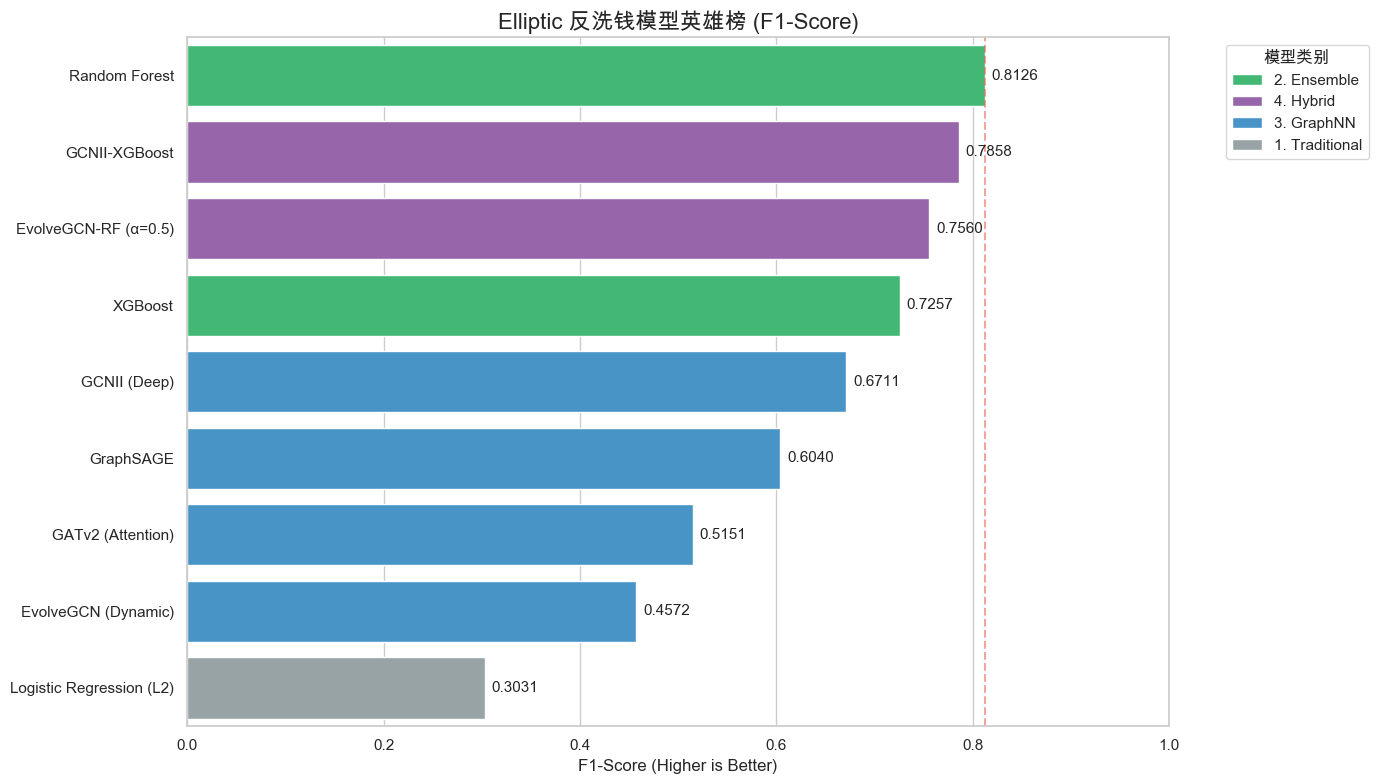


>>> [Section 2] Deep Dive into Champion Model (Random Forest)...


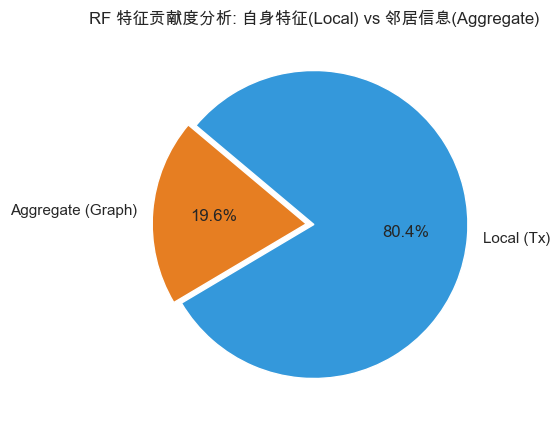

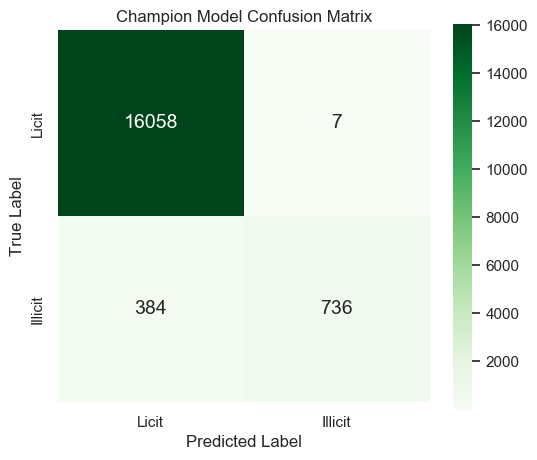


>>> [Section 3] Analyzing Temporal Robustness (Time 34-49)...


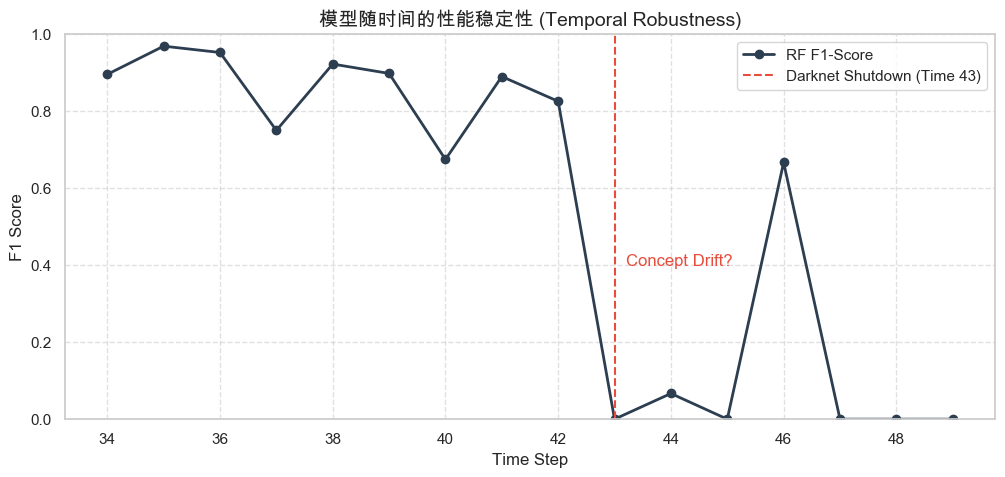


>>> [Section 4] Error Analysis: Who are the False Negatives?
漏抓样本数 (FN): 384
抓对样本数 (TP): 736


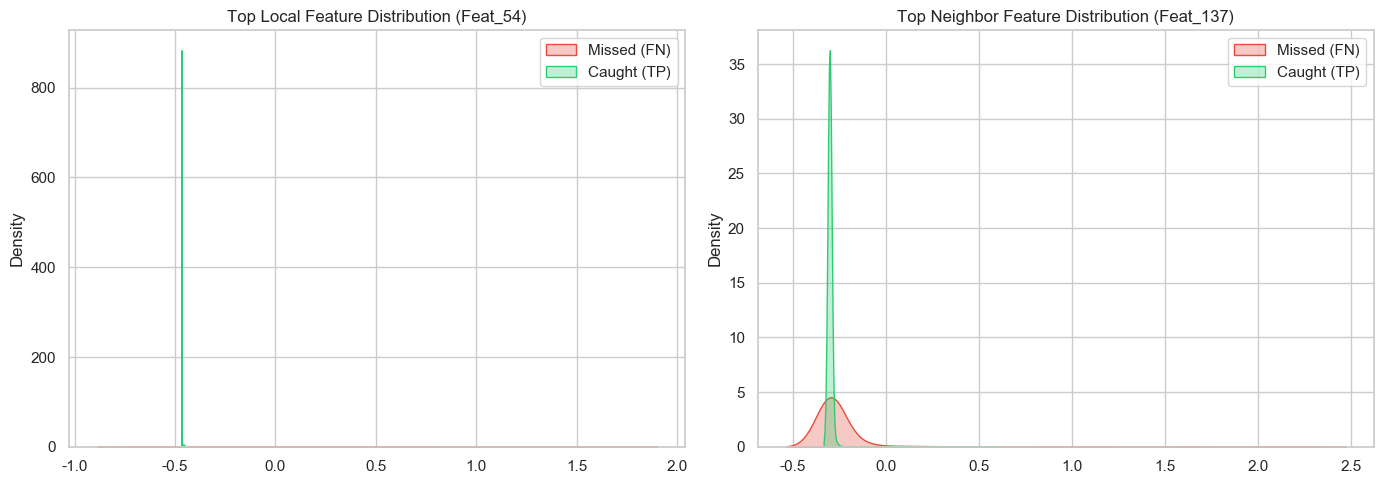


✅ Final Report Generated Successfully.


In [2]:
# ==============================================================================
# 11_Final_Report_and_Analysis.ipynb
# 目标：项目全景总结、SOTA 模型深度解析与误差分析
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# 设置绘图风格
sns.set_theme(style="whitegrid")
# 尝试兼容中文字体 (防止乱码)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print(">>> [Step 1] Loading Data for Analysis...")

# 1. 加载数据 (用于后续板块的深度分析)
# 如果你只是想看第一板块的英雄榜，可以跳过数据加载，直接运行 Section 1
data_loaded = False
try:
    PYG_DATA_PATH = '../data/processed/elliptic_pyg.pt'
    RAW_FEATURES_PATH = '../data/raw/elliptic_txs_features.csv'
    RAW_CLASSES_PATH = '../data/raw/elliptic_txs_classes.csv'

    data_all = torch.load(PYG_DATA_PATH, weights_only=False)
    X_all = data_all.x.numpy()
    y_all = data_all.y.numpy()

    # 时间切分逻辑
    df_classes = pd.read_csv(RAW_CLASSES_PATH)
    df_features = pd.read_csv(RAW_FEATURES_PATH, header=None, usecols=[0, 1], names=['txId', 'time_step'])
    df_merged = pd.merge(df_features, df_classes, on='txId', how='left')
    df_labeled = df_merged[df_merged['class'] != 'unknown'].copy()

    # 确定切分点 (Time 34)
    time_counts = df_labeled.groupby('time_step').size().sort_index()
    split_idx = time_counts.loc[:33].sum() # Time 1-34 (index 0-33)

    # 获取测试集的时间步信息 (用于时间稳定性分析)
    test_time_steps = df_labeled['time_step'].iloc[split_idx:].values

    X_train = X_all[:split_idx]
    y_train = y_all[:split_idx]
    X_test = X_all[split_idx:]
    y_test = y_all[split_idx:]

    data_loaded = True
    print(f"✅ Data Loaded. Test Set Size: {len(y_test)}")

except Exception as e:
    print(f"⚠️ Data Loading Skipped/Failed: {e}")
    print("   (你依然可以运行 [Section 1] 查看英雄榜图表)")

# ==============================================================================
# 2. [板块一] 英雄榜 (Leaderboard) - 全模型性能大比武 (修正版)
# ==============================================================================
print("\n>>> [Section 1] Generating Leaderboard...")

# 录入用户提供的真实实验数据
# 注意：这里的键名保持 'F1'，我们在创建 DataFrame 后统一重命名
leaderboard_data = [
    # 1. 传统模型 (Traditional)
    {'Model': 'Logistic Regression (L2)', 'F1': 0.3031, 'Category': '1. Traditional'},

    # 2. 集成模型 (Ensemble)
    {'Model': 'XGBoost',                  'F1': 0.7257, 'Category': '2. Ensemble'},
    {'Model': 'Random Forest',            'F1': 0.8126, 'Category': '2. Ensemble'}, # SOTA

    # 3. 图模型 (GraphNN)
    {'Model': 'GATv2 (Attention)',        'F1': 0.5151, 'Category': '3. GraphNN'},
    {'Model': 'GraphSAGE',                'F1': 0.6040, 'Category': '3. GraphNN'},
    {'Model': 'GCNII (Deep)',             'F1': 0.6711, 'Category': '3. GraphNN'},
    {'Model': 'EvolveGCN (Dynamic)',      'F1': 0.4572, 'Category': '3. GraphNN'},

    # 4. 混合模型 (Hybrid)
    {'Model': 'GCNII-XGBoost',            'F1': 0.7858, 'Category': '4. Hybrid'},
    {'Model': 'EvolveGCN-RF (α=0.5)',     'F1': 0.7560, 'Category': '4. Hybrid'},
]

df_res = pd.DataFrame(leaderboard_data)

# 🔥🔥🔥 [关键修正] 重命名列名以匹配绘图代码 🔥🔥🔥
df_res.rename(columns={'F1': 'F1-Score'}, inplace=True)

# 按 F1-Score 分数排序，方便展示
df_res = df_res.sort_values(by='F1-Score', ascending=False)

# 绘图
plt.figure(figsize=(14, 8))
palette = {
    '1. Traditional': '#95a5a6', # 灰
    '2. Ensemble':    '#2ecc71', # 绿 (冠军组)
    '3. GraphNN':     '#3498db', # 蓝
    '4. Hybrid':      '#9b59b6'  # 紫 (潜力组)
}

# 现在 x='F1-Score' 就能找到对应的列了
ax = sns.barplot(data=df_res, y='Model', x='F1-Score', hue='Category', palette=palette, dodge=False)

# 标注数值
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=5, fontsize=11, fontweight='bold')

plt.title('Elliptic 反洗钱模型英雄榜 (F1-Score)', fontsize=16, fontweight='bold')
plt.xlabel('F1-Score (Higher is Better)')
plt.ylabel('')
plt.xlim(0, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='模型类别')

# 添加 SOTA 辅助线
plt.axvline(x=0.8126, color='#e74c3c', linestyle='--', alpha=0.5, label='SOTA (RF)')

plt.tight_layout()
plt.show()

# ==============================================================================
# 3. [板块二] 冠军模型深度解析 (Champion Model Insights)
# ==============================================================================
if data_loaded:
    print("\n>>> [Section 2] Deep Dive into Champion Model (Random Forest)...")

    # 现场复现最佳 RF 模型 (为了获取特征重要性和预测结果)
    # 使用你提供的 RF 结果对应的配置 (Baseline RF or Optimized RF)
    # 这里使用通用强配置
    rf_best = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    rf_best.fit(X_train, y_train)
    y_pred_rf = rf_best.predict(X_test)

    # 3.1 特征重要性：Local (0-93) vs Aggregate (94-165)
    importances = rf_best.feature_importances_
    feat_types = ['Local (Tx)' if i < 94 else 'Aggregate (Graph)' for i in range(len(importances))]
    df_imp = pd.DataFrame({'Importance': importances, 'Type': feat_types})

    # 汇总两类特征的总贡献
    type_sum = df_imp.groupby('Type')['Importance'].sum()

    # 绘制饼图
    plt.figure(figsize=(8, 5))
    plt.pie(type_sum, labels=type_sum.index, autopct='%1.1f%%',
            colors=['#e67e22', '#3498db'], startangle=140, explode=[0.05, 0])
    plt.title('RF 特征贡献度分析: 自身特征(Local) vs 邻居信息(Aggregate)', fontweight='bold')
    plt.show()

    # 3.2 混淆矩阵
    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', square=True,
                xticklabels=['Licit', 'Illicit'], yticklabels=['Licit', 'Illicit'],
                annot_kws={"size": 14, "weight": "bold"})
    plt.title('Champion Model Confusion Matrix', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# ==============================================================================
# 4. [板块三] 时间稳定性分析 (Temporal Robustness)
# ==============================================================================
if data_loaded:
    print("\n>>> [Section 3] Analyzing Temporal Robustness (Time 34-49)...")

    time_steps = np.unique(test_time_steps)
    f1_by_time = []

    # 计算每个时间步的 F1
    for t in time_steps:
        mask = (test_time_steps == t)
        y_true_t = y_test[mask]
        y_pred_t = y_pred_rf[mask]

        if np.sum(y_true_t) > 0:
            f1 = f1_score(y_true_t, y_pred_t, pos_label=1)
        else:
            f1 = 0.0 # 该时间步无正样本
        f1_by_time.append(f1)

    plt.figure(figsize=(12, 5))
    plt.plot(time_steps, f1_by_time, marker='o', linewidth=2, color='#2c3e50', label='RF F1-Score')

    # 标注 Time 43 (暗网关闭事件)
    plt.axvline(x=43, color='#e74c3c', linestyle='--', label='Darknet Shutdown (Time 43)')
    plt.text(43.2, 0.4, 'Concept Drift?', color='#e74c3c', fontweight='bold')

    plt.title('模型随时间的性能稳定性 (Temporal Robustness)', fontsize=14, fontweight='bold')
    plt.xlabel('Time Step')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# ==============================================================================
# 5. [板块四] 误差分析 (Error Analysis)
# ==============================================================================
if data_loaded:
    print("\n>>> [Section 4] Error Analysis: Who are the False Negatives?")

    # 提取 False Negatives (漏抓) 和 True Positives (抓对)
    mask_fn = (y_test == 1) & (y_pred_rf == 0)
    mask_tp = (y_test == 1) & (y_pred_rf == 1)

    X_fn = X_test[mask_fn]
    X_tp = X_test[mask_tp]

    print(f"漏抓样本数 (FN): {len(X_fn)}")
    print(f"抓对样本数 (TP): {len(X_tp)}")

    # 对比最重要的 Local 特征 (通常是 Feat_0 或 Feat_1)
    # 和最重要的 Aggregate 特征 (通常在 94 之后)

    # 获取特征重要性排名
    indices = np.argsort(importances)[::-1]
    best_local = [i for i in indices if i < 94][0]     # 排名第一的 Local 特征
    best_agg = [i for i in indices if i >= 94][0]      # 排名第一的 Aggregate 特征

    plt.figure(figsize=(14, 5))

    # Local Feature 对比
    plt.subplot(1, 2, 1)
    sns.kdeplot(X_fn[:, best_local], label='Missed (FN)', fill=True, color='#e74c3c', alpha=0.3)
    sns.kdeplot(X_tp[:, best_local], label='Caught (TP)', fill=True, color='#2ecc71', alpha=0.3)
    plt.title(f'Top Local Feature Distribution (Feat_{best_local})', fontweight='bold')
    plt.legend()

    # Aggregate Feature 对比
    plt.subplot(1, 2, 2)
    sns.kdeplot(X_fn[:, best_agg], label='Missed (FN)', fill=True, color='#e74c3c', alpha=0.3)
    sns.kdeplot(X_tp[:, best_agg], label='Caught (TP)', fill=True, color='#2ecc71', alpha=0.3)
    plt.title(f'Top Neighbor Feature Distribution (Feat_{best_agg})', fontweight='bold')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\n✅ Final Report Generated Successfully.")